# Exploratory Data Analysis in PySpark on an EMR Cluster

Let's explore how you can use your PySpark coding skills in a JupyterHub notebook on an AWS EMR Cluster to perform an exploratory data analysis on large data sources. Specifically, we'll be revisiting our NYC Taxi Cab dataset that we worked with in Week 5, but this time, exploring data from the whole year of 2019 (as opposed to a single month). This dataset has billions of rows overall (80 million in 2019 alone) and would be challenging to work with in the absence of a scalable analytical framework like Spark. Note that this notebook is meant to be run on an EMR cluster, using a PySpark kernel.

First (after configuring our PySpark environment below to enable us to install packages in our notebook session), let's load the data from S3 into our Spark session. The data is spread across multiple CSV files, so we use the wildcard (\*) to indicate that we want the data from all of these files to be included within our dataframe, spread out over our EMR cluster in partitions. We're using the PySpark SQL `read.csv` method here so this wll be loaded into a Spark "DataFrame" -- which is built on top of an RDD (but has named columns -- as in a Pandas DataFrame).

In [ ]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [ ]:
df = spark.read.csv('s3://nyc-tlc/csv_backup/yellow_tripdata_2019*.csv', header=True)

Let's take a look at our data and see what it looks like. Note that just like a regular RDD, we can't actually see anything unless we perform an "action" on it.

In [3]:
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[VendorID: string, tpep_pickup_datetime: string, tpep_dropoff_datetime: string, passenger_count: string, trip_distance: string, RatecodeID: string, store_and_fwd_flag: string, PULocationID: string, DOLocationID: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string, congestion_surcharge: string]

In [4]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)

In [5]:
df.count() # an action to return total count of rows in dataset

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

84399019

Given that Spark DataFrames are built off of RDDs, we can still use methods like `take` to make small amounts of our data visible as list (we almost will never want to `collect` our data when working with big data, though; **ask**: Why?):

In [6]:
df.take(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(VendorID='1', tpep_pickup_datetime='2019-01-01 00:46:40', tpep_dropoff_datetime='2019-01-01 00:53:20', passenger_count='1', trip_distance='1.50', RatecodeID='1', store_and_fwd_flag='N', PULocationID='151', DOLocationID='239', payment_type='1', fare_amount='7', extra='0.5', mta_tax='0.5', tip_amount='1.65', tolls_amount='0', improvement_surcharge='0.3', total_amount='9.95', congestion_surcharge=None), Row(VendorID='1', tpep_pickup_datetime='2019-01-01 00:59:47', tpep_dropoff_datetime='2019-01-01 01:18:59', passenger_count='1', trip_distance='2.60', RatecodeID='1', store_and_fwd_flag='N', PULocationID='239', DOLocationID='246', payment_type='1', fare_amount='14', extra='0.5', mta_tax='0.5', tip_amount='1', tolls_amount='0', improvement_surcharge='0.3', total_amount='16.3', congestion_surcharge=None), Row(VendorID='2', tpep_pickup_datetime='2018-12-21 13:48:30', tpep_dropoff_datetime='2018-12-21 13:52:40', passenger_count='3', trip_distance='.00', RatecodeID='1', store_and_fwd_flag='

Spark SQL also includes a `show` method that makes this a bit prettier, though:

In [7]:
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2019-01-01 00:46:40|  2019-01-01 00:53:20|              1|         1.50|         1|                 N|         151|         239|           1|          7|  0.5|    0.5|      1.65|           0|                  0.3

## Exploring Data with Spark SQL

We have a couple of options for exploring our data via Spark SQL. We can first create a temporary "view" on which we can perform SQL queries, as we would in a database:

In [8]:
df.createOrReplaceTempView("taxi")
query = '''
        SELECT passenger_count, AVG(trip_distance) as avg_distance
        FROM taxi
        WHERE passenger_count > 3
        GROUP BY passenger_count
        ORDER BY passenger_count
        '''

df2 = spark.sql(query) # doesn't execute until perform "action"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
df2.show() # perform action

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------+
|passenger_count|      avg_distance|
+---------------+------------------+
|              4|3.1565533611494225|
|              5|3.0257764053566967|
|              6| 3.023783285960606|
|              7|3.2531250000000003|
|              8| 5.363898916967511|
|              9| 5.239200000000002|
+---------------+------------------+

Or we can use built-in methods and functions from Spark SQL to do the same thing on our Spark DataFrame directly:

In [10]:
import pyspark.sql.functions as F

df2_alt = df.filter(F.col('passenger_count') > 3) \
            .groupBy('passenger_count') \
            .agg(F.avg(F.col('trip_distance')) \
                  .alias('avg_distance')) \
            .orderBy(F.col('passenger_count'))

df2_alt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------+
|passenger_count|      avg_distance|
+---------------+------------------+
|              4|3.1565533611494216|
|              5|3.0257764053566967|
|              6| 3.023783285960606|
|              7|3.2531250000000003|
|              8| 5.363898916967508|
|              9|            5.2392|
+---------------+------------------+

## An aside on performance

At the beginning of the notebook, we loaded in our data in CSV format. However, we saw in Week 5 that this same data is available in Parquet format as well. Which one should we prefer? In general, [Parquet tends allow for faster read speeds in analytical contexts and also is smaller when saved to disk than CSV](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705). If we load the same data in as Parquet, you can see a huge difference in the time it takes to perform the same operations:

In [11]:
df_parquet = spark.read.parquet('s3://nyc-tlc/trip data/yellow_tripdata_2019*.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
import time
t0 = time.time()
df.count()
print("Count (CSV):", time.time() - t0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Count (CSV): 19.505754947662354

In [13]:
t0 = time.time()
df_parquet.count()
print("Count (Parquet):", time.time() - t0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Count (Parquet): 1.0056838989257812

In [14]:
t0 = time.time()
df.filter(F.col('passenger_count') > 3) \
           .groupBy('passenger_count') \
           .agg(F.avg(F.col('trip_distance')) \
                 .alias('avg_distance')) \
           .orderBy(F.col('passenger_count')) \
           .show()
print("Query (CSV):", time.time() - t0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------+
|passenger_count|      avg_distance|
+---------------+------------------+
|              4| 3.156553361149421|
|              5|3.0257764053566976|
|              6|3.0237832859606044|
|              7|3.2531249999999994|
|              8| 5.363898916967509|
|              9|            5.2392|
+---------------+------------------+

Query (CSV): 41.480769634246826

In [15]:
t0 = time.time()
df_parquet.filter(F.col('passenger_count') > 3) \
            .groupBy('passenger_count') \
            .agg(F.avg(F.col('trip_distance')) \
                  .alias('avg_distance')) \
            .orderBy(F.col('passenger_count')) \
            .show()
print("Query (Parquet):", time.time() - t0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------+
|passenger_count|      avg_distance|
+---------------+------------------+
|            4.0|3.1565478227049333|
|            5.0| 3.025776405356713|
|            6.0| 3.023784768827353|
|            7.0|          3.253125|
|            8.0| 5.363898916967508|
|            9.0|            5.2392|
+---------------+------------------+

Query (Parquet): 2.8593482971191406

So, it's strongly recommended that you work with Parquet files for analytical workloads as opposed to text-based formats like CSV and JSON (it can sometimes even make sense to just convert existing files into Parquet format for the purposes of analysis). This becomes especially important as your data size increases further than what we're working with in this demo.

## Plotting Exploratory Findings

An important part of exploratory data analysis is visualizing your findings. Unfortunately, we do not have a plotting library installed on our cluster!

In [16]:
import matplotlib.pyplot as plt # matplotlib not installed by default!

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
No module named 'matplotlib'
Traceback (most recent call last):
ModuleNotFoundError: No module named 'matplotlib'



We can see packages that we currently have available in our Spark context, though, by using the `list_packages` method and install additional packages via the `install_pypi_package` method:

In [17]:
sc.list_packages()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version   
-------------------------- ----------
beautifulsoup4             4.9.3     
boto                       2.49.0    
click                      7.1.2     
jmespath                   0.10.0    
joblib                     0.17.0    
lxml                       4.6.1     
mysqlclient                1.4.2     
nltk                       3.5       
nose                       1.3.4     
numpy                      1.16.5    
pip                        9.0.1     
py-dateutil                2.2       
python37-sagemaker-pyspark 1.4.1     
pytz                       2020.1    
PyYAML                     5.3.1     
regex                      2020.10.28
setuptools                 28.8.0    
six                        1.13.0    
tqdm                       4.51.0    
wheel                      0.29.0    
windmill                   1.6

In [ ]:
sc.install_pypi_package("boto3==1.19.2")
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")

In [19]:
sc.list_packages() # everything is installed now!

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version   
-------------------------- ----------
beautifulsoup4             4.9.3     
boto                       2.49.0    
boto3                      1.19.2    
botocore                   1.22.12   
click                      7.1.2     
cycler                     0.11.0    
jmespath                   0.10.0    
joblib                     0.17.0    
kiwisolver                 1.4.4     
lxml                       4.6.1     
matplotlib                 3.2.1     
mysqlclient                1.4.2     
nltk                       3.5       
nose                       1.3.4     
numpy                      1.16.5    
pandas                     1.0.5     
pip                        9.0.1     
py-dateutil                2.2       
pyparsing                  3.0.9     
python-dateutil            2.8.2     
python37-sagemaker-pyspark 1.4.1     
pytz                       2020.1    
PyYAML                     5.3.1     
regex                      2020.10.28
s3transfer  

Now that we have installed our plotting libraries (and Pandas), we can convert our Spark DataFrame into a Pandas DataFrame and use our plotting libraries as normal. Note that this is a small dataframe, but you want to be careful with converting data to Pandas, as all of this data is being made accessible on the primary node (and is no longer distributed). Therefore, in general, it is best to do the computational work in Spark before passing smaller output for visualization to Seaborn/Matplotlib:

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

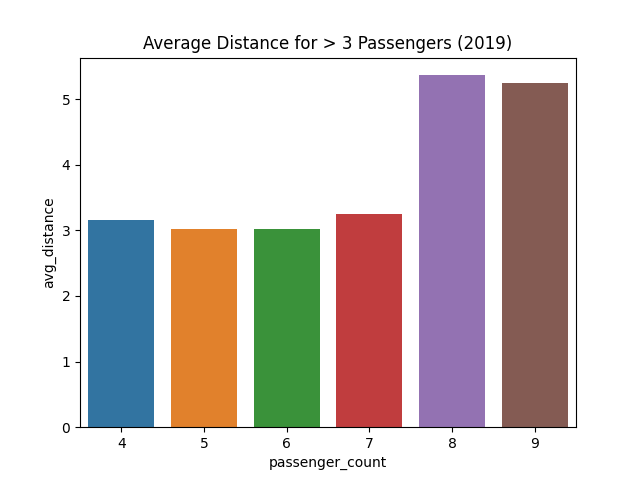

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# convert to Pandas DataFrame in order to plot
pdf = df2.toPandas()

# Close previous plots; otherwise, will just overwrite and display again
plt.close()

sns.barplot(x='passenger_count', y='avg_distance', data=pdf)
plt.title('Average Distance for > 3 Passengers (2019)')

%matplot plt

If you must visualize point data, for instance, in your EDA, you will see better results (and lessen your risk of running out of memory on your primary node) if you take a small random sample of the distributed DataFrame and only plot that sample. We'll take a look at some other strategies for visualizing large datasets in Week 9, but this will tend to be your best bet using standard Python plotting libraries alone:

In [24]:
sampled_df = df_parquet.sample(fraction=0.00001)
pdf_sampled = sampled_df.toPandas()
pdf_sampled.VendorID.count() # much smaller

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

889

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

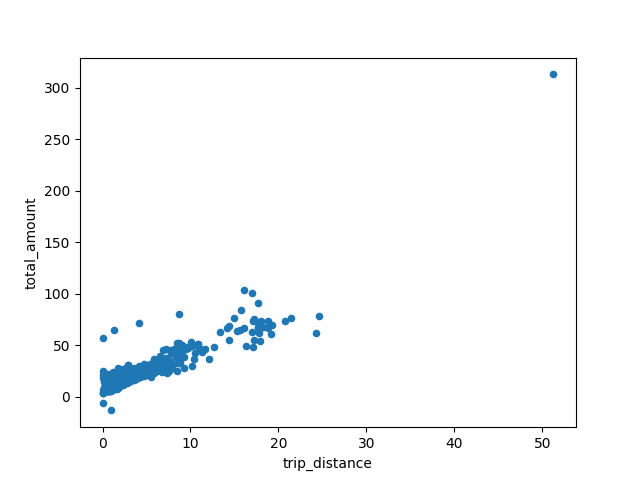

In [25]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

pdf_sampled.plot.scatter('trip_distance', 'total_amount')

%matplot plt

## Activity

1. What were the top 4 drop-off location IDs (in terms of trip frequency) during 2019? Note (Optional): if you're curious, you can look up the ID meanings [in a supplemental file in the same S3 bucket](https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv).
2. Read in the 2020 Yellow Cab trips data and run the same query. How does the frequency of the top 4 drop-off locations change from 2019 to 2020?

If you have time, produce a plot to visualize the change between the two years.